# Mastering Antigranular Fundamentals Part 2: 🧠 A Quick Overview of What to Expect 🤗

This notebook is in continuation from our last notebook [Mastering Antigranular Fundamentals](https://www.antigranular.com/notebooks/mastering_ag_fundamentals_quick_overview_of_what_to_expect_in_ag), so if you have not already gone through it, you should.

In this notebook, we will be going over handling of the "Categorical" columns, and how is it different to handle in the AG kernel.

Let's get started. 🎉

First, let's install the antigranular package. ✅

In [ ]:
!pip install antigranular

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The above packages are the same as in the last notebook, and would be required for the basic data science and graph plotting.

Next, we will download the dataset and prepare it in the same way we did last time.

In [ ]:
URL = 'https://content.antigranular.com/image/notebook_content/Salary.csv'
df = pd.read_csv(URL)
df.drop_duplicates(inplace = True)

Next step is to login to the AG server, and start the AG kernel.

In [ ]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset="Drug Dataset")
session.private_import(df, "ag_df")

Dataset "Drug Dataset" loaded to the kernel as drug_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: ab5ebd03-7a6a-4021-8a04-2ff13d8b19bf, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!
dataframe cached to server, loading to kernel...
DataFrame loaded successfully to the kernel



Unlike the last time, we are going to add some metadata to the categorical columns.

For all the datasets, and competitions that you will work with, provided by Antigranular, metadata will always be provided. The metadata could be either numerical or categorical.


*   Numerical Metadata - This covers the bounds of the column. The minimum and the maximum possible values for the columns.
*   Categorical Metadata - This covers the categories for the column. The unique values possible for the column.



In [ ]:
%%ag
from op_pandas import PrivateDataFrame
pdf = PrivateDataFrame(ag_df, categorical_metadata={"Gender": ["Male", "Female"], "Country": ["Australia", "Canada", "China", "UK", "USA"]})
ag_print(pdf.info())
ag_print(pdf.categorical_metadata)

+----+---------------------+-------------+---------------+---------+-------------------+
|    | Column              | numerical   | categorical   | dtype   | bounds            |
|----+---------------------+-------------+---------------+---------+-------------------|
|  0 | Age                 | True        | False         | float64 | (21.0, 62.0)      |
|  1 | Gender              | False       | True          | object  | None              |
|  2 | Education Level     | True        | False         | int64   | (0, 3)            |
|  3 | Job Title           | False       | False         | object  | None              |
|  4 | Years of Experience | True        | False         | float64 | (0.0, 34.0)       |
|  5 | Salary              | True        | False         | float64 | (350.0, 250000.0) |
|  6 | Country             | False       | True          | object  | None              |
|  7 | Race                | False       | False         | object  | None              |
|  8 | Senior        

In [ ]:
%%ag
ag_print(pdf["Gender"].categorical_metadata)

['Male', 'Female']



In the last notebook, we created histograms for numerical columns, this time we will be doing it for two of the categorical columns - "Gender" and "Country". In regular environments, drawing graphs for a categorical column is straightforward as shown below.


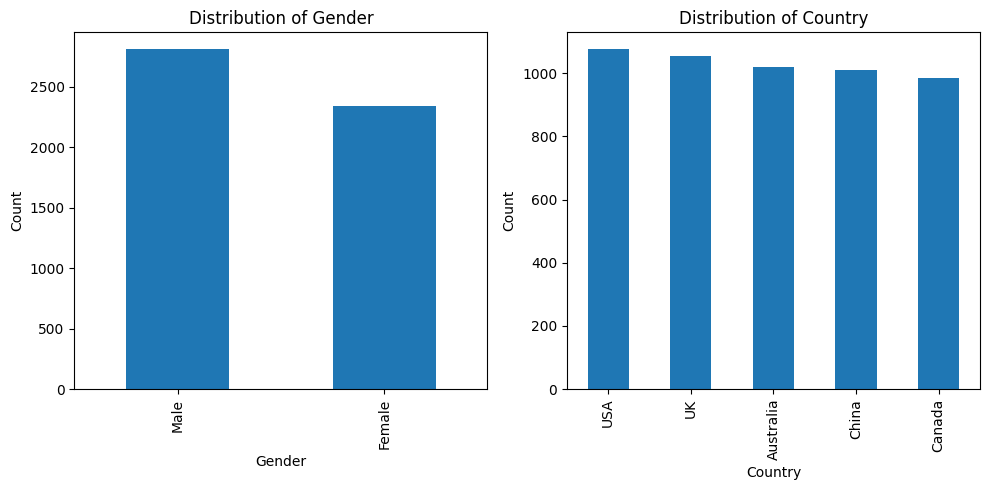

In [ ]:
# plain df, categories to
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5 * 2, 5))
for col, ax in zip(["Gender", "Country"], axes):
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

But when it comes to the AG kernel, and working with a PrivateDataFrame, we cannot simply plot it in the same way as numerical columns. The categories are useful, only when they are in the resultant set.

We have to map the values to be numerical first, and then we could do any kind of data science on it. To change the categories to a numerical value, we have a few ways.


1.   Mapping function
2.   Mapping dictionary
3.   Label Transformers.

We are going to execute the **map** method of the PrivateSeries class, and use a mapping function and a mapping dictionary to convert the columns "Gender" and "Country".





In [ ]:
%%ag
from pandas import DataFrame
def func_gender(x: str) -> float:
  data = {
      "Male": 1, "Female": 0
  }
  return data.get(x, 2)

result_gender = pdf["Gender"].map(func_gender,eps=1) # Using a func to transform
result_gender.make_series_non_categorical(output_bounds=(0,1)) # describe does not work on categorical columns
result_country = pdf["Country"].map({'Australia': 0, 'Canada': 1, 'China': 2, 'UK': 3, 'USA': 4}) # Using a mapping to transform
result_country.make_series_non_categorical(output_bounds=(0,4)) # for using in hist
cols_to_keep = [col for col in pdf.columns if col not in ["Gender", "Country"]]
pdf_updated = pdf[cols_to_keep].join(result_gender, how="inner").join(result_country, how="inner")

We have also used the method "make_series_non_categorical". This method removes the categories from the metadata, and marks the column as not "categorical". If this is not done, then you would not be able to call the **describe** method, because it does not support those columns as of now.

It also does not work with the **hist** method.

In [ ]:
%%ag
ag_print(pdf_updated.info())

+----+---------------------+-------------+---------------+---------+-------------------+
|    | Column              | numerical   | categorical   | dtype   | bounds            |
|----+---------------------+-------------+---------------+---------+-------------------|
|  0 | Age                 | True        | False         | float64 | (21.0, 62.0)      |
|  1 | Education Level     | True        | False         | int64   | (0, 3)            |
|  2 | Job Title           | False       | False         | object  | None              |
|  3 | Years of Experience | True        | False         | float64 | (0.0, 34.0)       |
|  4 | Salary              | True        | False         | float64 | (350.0, 250000.0) |
|  5 | Race                | False       | False         | object  | None              |
|  6 | Senior              | True        | False         | int64   | (0, 1)            |
|  7 | Gender              | True        | False         | int64   | (0, 1)            |
|  8 | Country       

In [ ]:
%%ag
ag_print(pdf_updated.categorical_metadata)

{}



We are going to plot the graph for the columns "Gender" and "Country" with different epsilon values, to demonstrate the difference in the results with varying noise.

More the **epsilon**, better the result.

In [ ]:
%%ag
import numpy as np
hist_data={"0.01": {}, "1": {}}
hist_data["0.01"]["Gender"] = pdf_updated.hist(column="Gender", eps=0.01, bins=[0,1,2])
hist_data["0.01"]["Country"] = pdf_updated.hist(column="Country", eps=0.01, bins=[0,1,2,3,4,5])
hist_data["1"]["Gender"] = pdf_updated.hist(column="Gender", eps=1, bins=[0,1,2])
hist_data["1"]["Country"] = pdf_updated.hist(column="Country", eps=1, bins=[0,1,2,3,4,5])
export(hist_data,"hist_data")

Setting up exported variable in local environment: hist_data


We will now plot both the DataFrame and PrivateDataFrame (with different epsilon), side by side, to see the difference between the results.

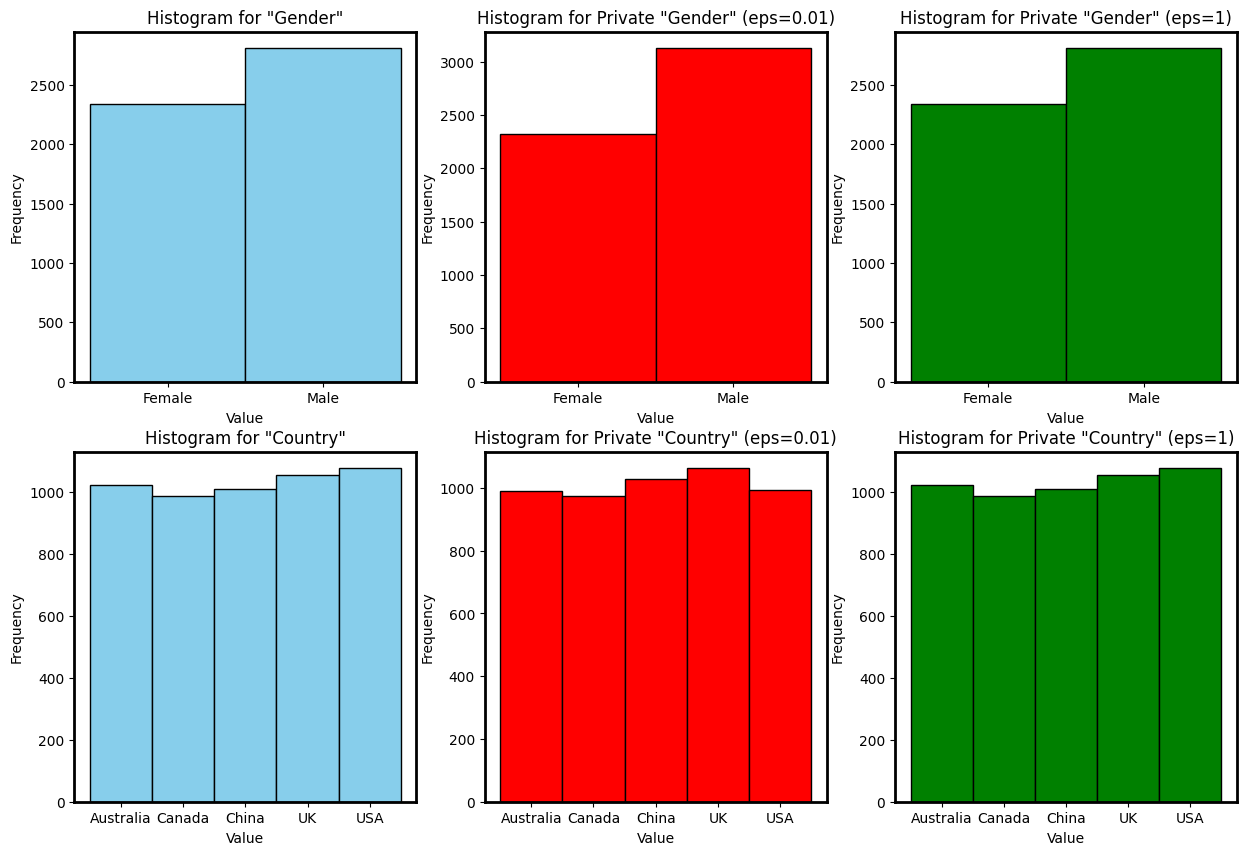

In [ ]:
#Seperating frequencies and edges of PrivateDataFrame result
hist_df = pd.DataFrame(hist_data["0.01"])
pdf_frequencies_001 = [hist_df[column][0] for column in hist_df.columns]
pdf_bin_edges_001  = [hist_df[column][1] for column in hist_df.columns]
hist_df = pd.DataFrame(hist_data["1"])
pdf_frequencies_1 = [hist_df[column][0] for column in hist_df.columns]
pdf_bin_edges_1  = [hist_df[column][1] for column in hist_df.columns]

df_hist_data = {}
gender_unique_categories, gender_numerical_data = np.unique(df['Gender'], return_inverse=True)
df_hist_data["Gender"] = np.histogram(gender_numerical_data, bins=np.arange(3)-0.5)
country_unique_categories, country_numerical_data = np.unique(df['Country'], return_inverse=True)
df_hist_data["Country"] = np.histogram(country_numerical_data, bins=np.arange(6)-0.5)
#Seperating frequencies and edges of DataFrame result
df_frequencies = [df_hist_data[col][0] for col in df_hist_data]
df_bin_edges  = [df_hist_data[col][1] for col in df_hist_data]

n_rows = 2
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 10),) #setting 2 columns, one for DataFrame and one for PrivateDataFrame
#Adjusting space between the graphs
# plt.subplots_adjust(wspace=2, hspace=2)

for i,col in enumerate(hist_df.columns):
    # Calculate bin widths and centers
    pdf_bin_widths_001 = np.diff(pdf_bin_edges_001[i])
    pdf_bin_centers_001 = pdf_bin_edges_001[i][:-1] + pdf_bin_widths_001 / 2
    pdf_bin_widths_1 = np.diff(pdf_bin_edges_1[i])
    pdf_bin_centers_1 = pdf_bin_edges_1[i][:-1] + pdf_bin_widths_1 / 2
    df_bin_widths = np.diff(df_bin_edges[i])
    df_bin_centers = df_bin_edges[i][:-1] + df_bin_widths / 2

    # Plotting for DataFrame
    axes[i][0].bar(df_bin_centers, df_frequencies[i], width=df_bin_widths, align='center', color = "skyblue", edgecolor="black")
    axes[i][0].set_xlabel('Value')
    axes[i][0].set_ylabel('Frequency')
    axes[i][0].set_title(f'Histogram for \"{col}\"')

    # Plotting for PrivateDataFrame
    axes[i][1].bar(pdf_bin_centers_001, pdf_frequencies_001[i], width=pdf_bin_widths_001, align='center', color = "red", edgecolor="black",)
    axes[i][1].set_title(f'Histogram for Private \"{col}\" (eps=0.01)')
    axes[i][1].set_xlabel('Value')
    axes[i][1].set_ylabel('Frequency')

    axes[i][2].bar(pdf_bin_centers_1, pdf_frequencies_1[i], width=pdf_bin_widths_1, align='center', color = "green", edgecolor="black",)
    axes[i][2].set_title(f'Histogram for Private \"{col}\" (eps=1)')
    axes[i][2].set_xlabel('Value')
    axes[i][2].set_ylabel('Frequency')

    if col=="Gender":
       axes[i][0].set_xticks([0,1], labels = gender_unique_categories)
       axes[i][1].set_xticks([0.5,1.5], labels = gender_unique_categories)
       axes[i][2].set_xticks([0.5,1.5], labels = gender_unique_categories)
    elif col =="Country":

       axes[i][0].set_xticks([0,1,2,3,4], labels = country_unique_categories)
       axes[i][1].set_xticks([0.5,1.5,2.5,3.5,4.5], labels = ["Australia", "Canada", "China", "UK", "USA"])
       axes[i][2].set_xticks([0.5,1.5,2.5,3.5,4.5], labels = ["Australia", "Canada", "China", "UK", "USA"])

# Add borrder to the plots
for ax in axes.flat:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

If you look at the results closely, you will see that the results with epsilon 0.01, are not close to the actual result, whereas with epsilon 1, we get much better results, nearly identical.

Let's plot the correlation matrix now, with three different epsilon values - 0.01, 1 and 10.

In [ ]:
%%ag
pdf_correlation_matrix_0_01 = pdf_updated.corr(eps = 0.01)
pdf_correlation_matrix_1 = pdf_updated.corr(eps = 1)
pdf_correlation_matrix_10 = pdf_updated.corr(eps = 10)

export(pdf_correlation_matrix_1,"pdf_correlation_matrix_1")
export(pdf_correlation_matrix_0_01, "pdf_correlation_matrix_0_01")
export(pdf_correlation_matrix_10, "pdf_correlation_matrix_10")

Setting up exported variable in local environment: pdf_correlation_matrix_1
Setting up exported variable in local environment: pdf_correlation_matrix_0_01
Setting up exported variable in local environment: pdf_correlation_matrix_10


Renaming the columns to shorter names, and converting the type of the columns to float.

In [ ]:
df_copy = df.copy()
df_copy["Gender"] = df_copy["Gender"].map({"Female": 0, "Male": 1})
df_copy["Country"] = df_copy["Country"].map({'Australia': 0, 'Canada': 1, 'China': 2, 'UK': 3, 'USA': 4})
df_correlation_matrix = df_copy.corr()
df_correlation_matrix = df_correlation_matrix.rename(columns={"Education Level":"EL","Years of Experience": "YE"}, index={"Education Level":"EL","Years of Experience": "YE"})
pdf_correlation_matrix_0_01 = pdf_correlation_matrix_0_01.fillna(0).astype(float)
pdf_correlation_matrix_1 = pdf_correlation_matrix_1.astype(float)
pdf_correlation_matrix_10 = pdf_correlation_matrix_10.astype(float)
pdf_correlation_matrix_0_01 = pdf_correlation_matrix_0_01.rename(columns={"Education Level":"EL","Years of Experience": "YE"}, index={"Education Level":"EL","Years of Experience": "YE"})
pdf_correlation_matrix_1 = pdf_correlation_matrix_1.rename(columns={"Education Level":"EL","Years of Experience": "YE"}, index={"Education Level":"EL","Years of Experience": "YE"})
pdf_correlation_matrix_10 = pdf_correlation_matrix_10.rename(columns={"Education Level":"EL","Years of Experience": "YE"}, index={"Education Level":"EL","Years of Experience": "YE"})

<ipython-input-14-31316faf92b8>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_correlation_matrix = df_copy.corr()


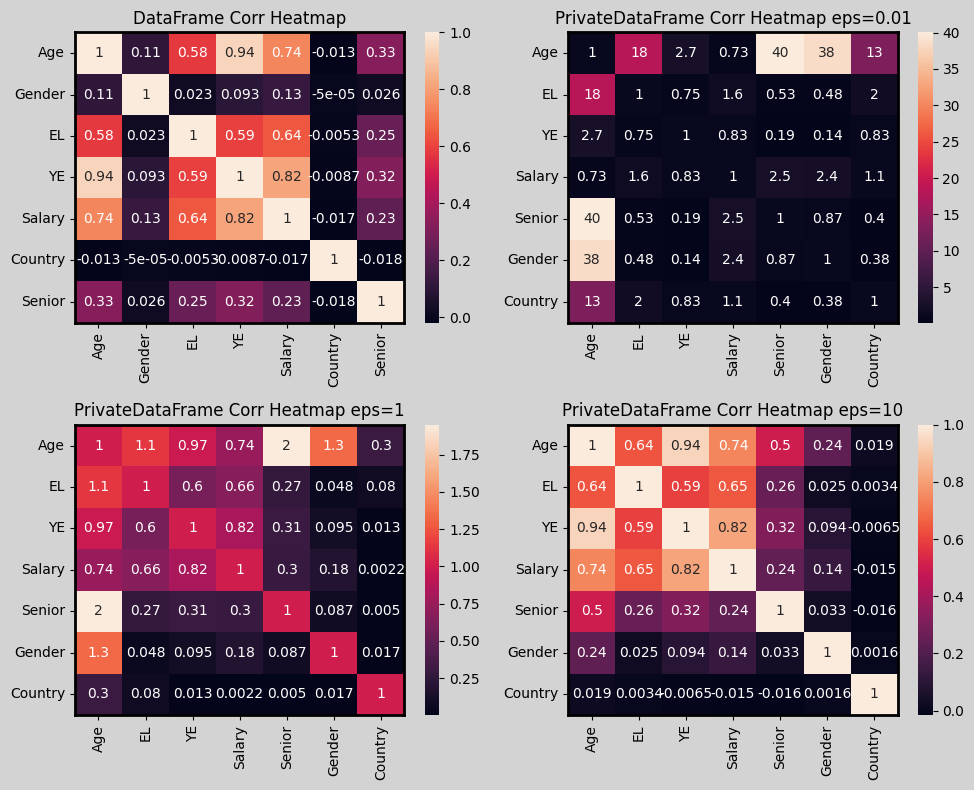

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(10 , 8))
sns.heatmap(df_correlation_matrix, ax=axes[0][0], annot=True)
sns.heatmap(pdf_correlation_matrix_0_01, ax=axes[0][1], annot=True)
sns.heatmap(pdf_correlation_matrix_1, ax=axes[1][0], annot=True)
sns.heatmap(pdf_correlation_matrix_10, ax=axes[1][1], annot=True)

axes[0][0].set_title("DataFrame Corr Heatmap")
axes[0][1].set_title("PrivateDataFrame Corr Heatmap eps=0.01")
axes[1][0].set_title("PrivateDataFrame Corr Heatmap eps=1")
axes[1][1].set_title("PrivateDataFrame Corr Heatmap eps=10")

# Add borrder to the plots
for ax in axes.flat:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

# Add background
fig.patch.set_facecolor('lightgrey')

plt.tight_layout()
plt.show()

The correlation matrix gets more closer to the actual results with the increasing epsilon.

# Modelling


The next part of this notebook covers how to apply a model (in this case, a classification model) on a DataFrame and a PrivateDataFrame.

To use any predictive models, we will need to choose a column which best suits as the predictive result. For this dataset, we will go ahead with the column "Salary". But "Salary" is a numerical columns, and has ranging values. A prediction result should ideally be a categorical column.

Therefore, we will first convert the "Salary" column values to a list of fixed values based on some rules. We can choose the rules, based on how the values are distributed. Below is the histogram of the "Salary" values.

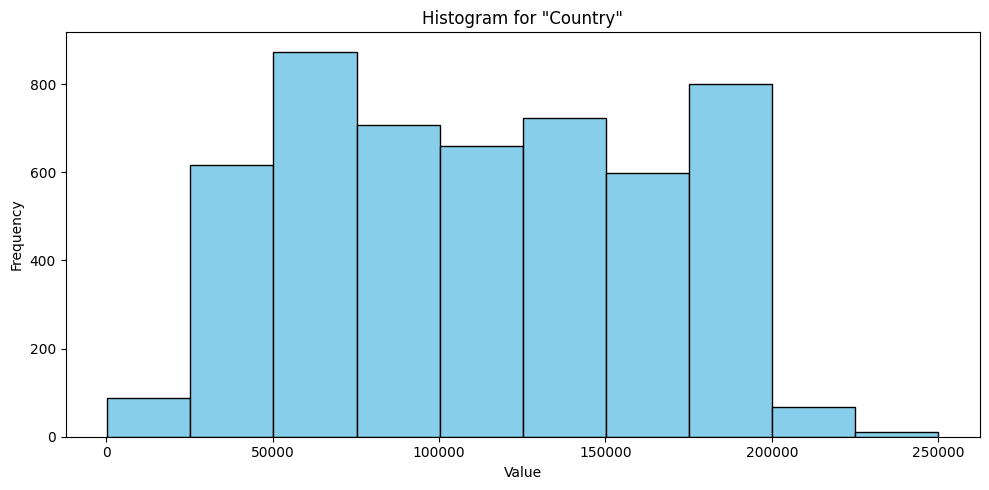

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5 * 2, 5))
frequencies,bin_edges = np.histogram(df["Salary"], bins=10)
bin_widths = np.diff(bin_edges)
bin_centers = bin_edges[:-1] + bin_widths / 2
axes.bar(bin_centers, frequencies, width=bin_widths, align='center', color = "skyblue", edgecolor="black")
axes.set_xlabel('Value')
axes.set_ylabel('Frequency')
axes.set_title(f'Histogram for \"{col}\"')
plt.tight_layout()
plt.show()

We can choose the bins based on the graph. Below is a sample method for dividing the "Salary" column into categories.

In [ ]:
def map_salary(x: float) -> int:
  if x >= 200000:
    return 4
  elif x >= 150000:
    return 3
  elif x >= 100000:
    return 2
  elif x >= 50000:
    return 1
  else:
    return 0

We will now divide the dataset into the training and test sets. The below code divides the dataset, keeping 20% of the records as the test set.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Salary"])  # Features (drop target columns)
Y = df["Salary"].map(map_salary)  # Target (Categorized Salary)

# Train-test split (80% train, 20% test)
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)


We will push the datasets to the AG kernel and then convert the train datasets to PrivateDataFrame.


In [ ]:
session.private_import(train_x, "train_x")
session.private_import(test_x, "test_x")
session.private_import(train_y, "train_y")

dataframe cached to server, loading to kernel...
DataFrame loaded successfully to the kernel

dataframe cached to server, loading to kernel...
DataFrame loaded successfully to the kernel

series cached to server, loading to kernel...
Series loaded successfully to the kernel



In [ ]:
!pip install diffprivlib

We are going to apply the classifier first in the local environment, predict the result and then get the accuracy. We will be applying the model on the whole dataset, except the two remaining categorical columns.

In [ ]:
from diffprivlib.models import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

train_x_copy = train_x.copy()
train_x_copy["Gender"] = train_x["Gender"].map({"Female": 0, "Male": 1})
train_x_copy["Country"] = train_x["Country"].map({'Australia': 0, 'Canada': 1, 'China': 2, 'UK': 3, 'USA': 4})
cols_to_keep = [col for col in train_x.columns if col not in ["Gender", "Country", "Job Title", "Race"]]
train_x_copy = train_x_copy[cols_to_keep]

classifier = RandomForestClassifier(n_estimators=150, random_state=50)
classifier.fit(train_x_copy,train_y)

#Updating test_x in the same way
test_x_copy = test_x.copy()
test_x_copy["Gender"] = test_x["Gender"].map({"Female": 0, "Male": 1})
test_x_copy["Country"] = test_x["Country"].map({'Australia': 0, 'Canada': 1, 'China': 2, 'UK': 3, 'USA': 4})
cols_to_keep = [col for col in test_x.columns if col not in ["Gender", "Country", "Job Title", "Race"]]
test_x_copy = test_x_copy[cols_to_keep]

prediction = classifier.predict(test_x_copy)
accuracy = accuracy_score(test_y, prediction)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(test_y, prediction))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.11/dist-packages/diffprivlib/models/forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional priva

Model Accuracy: 0.6282

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.58      0.72       111
           1       0.58      0.86      0.69       318
           2       0.68      0.30      0.42       277
           3       0.62      0.77      0.68       295
           4       0.00      0.00      0.00        29

    accuracy                           0.63      1030
   macro avg       0.56      0.50      0.50      1030
weighted avg       0.64      0.63      0.60      1030



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



We will perform the exact same thing in the AG kernel, but before that we will convert the train_x and train_y to PrivateDataFrame. This is because all the datasets you will encounter on the AG kernel will have the training sets as PrivateDataFrame.

We will then prepare the training PDF, train the model on it, prepare the test dataset, and predict based on it.

Note - The warning you see above is because we have not provided the classes and the bounds for the model. This is required in the AG kernel.


In [ ]:
%%ag
from op_diffprivlib.models import RandomForestClassifier

private_train_x = PrivateDataFrame(DataFrame(train_x))
private_train_y = PrivateDataFrame(DataFrame(train_y))

result_gender = private_train_x["Gender"].map({"Female": 0, "Male": 1}, eps=1) # Using a func to transform
result_country = private_train_x["Country"].map({'Australia': 0, 'Canada': 1, 'China': 2, 'UK': 3, 'USA': 4}, eps=1) # Using a mapping to transform
cols_to_keep = [col for col in train_x.columns if col not in ["Gender", "Country", "Job Title", "Race"]]
private_train_x = private_train_x[cols_to_keep].join(result_gender, how="inner").join(result_country, how="inner")

classifier = RandomForestClassifier(epsilon=1, classes=[0,1,2,3,4], bounds=(0,5), n_estimators=150, random_state=50)
classifier.fit(private_train_x,private_train_y)


result_gender = test_x["Gender"].map({"Female": 0, "Male": 1}) # Using a func to transform
result_country = test_x["Country"].map({'Australia': 0, 'Canada': 1, 'China': 2, 'UK': 3, 'USA': 4}) # Using a mapping to transform
cols_to_keep = [col for col in test_x.columns if col not in ["Gender", "Country", "Job Title", "Race"]]
test_x_copy = test_x[cols_to_keep].join(result_gender, how="inner").join(result_country, how="inner")

prediction = classifier.predict(test_x_copy)

export(prediction,"dp_prediction")

/usr/local/lib/python3.10/site-packages/ag_wrapper/wrapper.py:129: UserWarning: Bounds estimation epsilon is set to 0.1. It wont be charged until a private dataframe / series ispassed to predict or transform methods.
  warnings.warn(f"Bounds estimation epsilon is set to {bounds_estimation_eps}. It wont be charged until "
/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Setting up exported variable in local environment: dp_prediction


/usr/local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



In [ ]:
dp_accuracy = accuracy_score(test_y, dp_prediction)
print(f"Model Accuracy with DP: {dp_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(test_y, dp_prediction))

Model Accuracy with DP: 0.5039

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.07      0.13       111
           1       0.50      0.88      0.64       318
           2       0.20      0.00      0.01       277
           3       0.50      0.78      0.61       295
           4       0.00      0.00      0.00        29

    accuracy                           0.50      1030
   macro avg       0.44      0.35      0.28      1030
weighted avg       0.46      0.50      0.39      1030



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The difference in the accuracy result is quite distinctive.

In [ ]:
session.terminate_session()

{'status': 'ok'}

In the next notebook, we will look at how we can modify the model in order to get better accuracy results, based on the dataset. We will also look at a few more models that can be applied to the datasets.